In [28]:
# This code is based on:
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

# Import required libraries
import os
import utils
import xml.etree.ElementTree as ET

import torch
import torchvision
import matplotlib.pyplot as plt

from engine import train_one_epoch, evaluate

# Define root directory (where data and annotations are located)
root_dir = "../Dataset"

In [2]:
def extract_bboxes(annotation_path):
    """
    This function extracts bounding boxes coordinates and label from xml file
    - Input: annotation_path, path of xml file with annotation
    - Output:
        - bboxes: coordinates (x0, y0, x1, y1) for each bounding box (n x 4) tensor
        - label: label for each bounding box (n x 1) tensor where n is the number of bounding boxes in the image
    """
    
    # Getting bounding boxes coordinates and label of image
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    objects = root.findall("object")
    bboxes = []
    labels = []
    for obj in objects:
        l = int(obj.find("name").text) + 1  # Get label add 1 becuase label 0 is for background and
        # IP102 dataset does not contain background label
        # Get bounding box coordinates
        bbox = obj.find("bndbox")
        x0 = int(bbox.find("xmin").text)
        y0 = int(bbox.find("ymin").text)
        x1 = int(bbox.find("xmax").text)
        y1 = int(bbox.find("ymax").text)

        bboxes.append([x0, y0, x1, y1])
        labels.append(l)

    return torch.tensor(bboxes), torch.tensor(labels)

In [3]:
# Create dictionary that maps integer class index to string with name of class
file = os.path.join(root_dir, "classes.txt")   # txt file containing the name of the corresponding class

with open(file, "r") as file:
    lines = file.readlines()

classes = {}

# Get key and value for each class (line of txt file)
for line in lines:
    key, value = line.strip().split(" ", 1)
    classes[int(key.strip())] = value.strip()

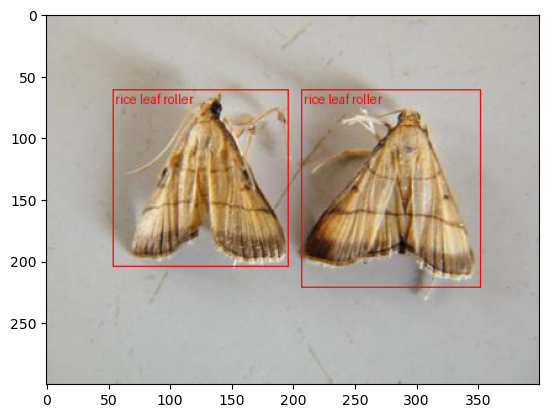

In [4]:
# Show an image from IP102 dataset with bounding boxes
image = torchvision.io.read_image(os.path.join(root_dir, "JPEGImages/IP000000002.jpg"))
bboxes, labels = extract_bboxes(os.path.join(root_dir, "Annotations/IP000000002.xml"))
drawn_boxes = torchvision.utils.draw_bounding_boxes(image, bboxes, colors="red", labels=[classes[int(l)] for l in labels])
plt.imshow(drawn_boxes.permute(1, 2, 0))

In [5]:
# Writing custom dataset class for IP102
class IP102(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # Load all images and annotations, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "JPEGImages"))))
        self.annots = list(sorted(os.listdir(os.path.join(root, "Annotations"))))
        
    def __getitem__(self, idx):
        # Function for getting and image from dataset
        # Load image and annotation
        img_path = os.path.join(self.root, "JPEGImages", self.imgs[idx])
        annot_path = os.path.join(self.root, "Annotations", self.annots[idx])
        img = torchvision.io.read_image(img_path)
        # Extract bounding box from annotation file
        bboxes, labels = extract_bboxes(annot_path)
        
        image_id = idx
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        
        img = torchvision.tv_tensors.Image(img)
        
        target = {}
        target["boxes"] = torchvision.tv_tensors.BoundingBoxes(bboxes, format="XYXY", 
        canvas_size=torchvision.transforms.v2.functional.get_size(img))
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    
    def __len__(self):
        # Number of images in dataset
        return len(self.imgs)

In [6]:
# Create a model pre-trained with COCO dataset and finetune it to IP102 dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

# Replace the classifier with a new one that has 102 classes
num_classes = len(classes) + 1 
# Number of input features for classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Replace pretrained head with new one
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

In [8]:
# Download helper functions for training and evaluating detection models
os.system("wget -nc https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget -nc https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget -nc https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget -nc https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget -nc https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

El fichero «engine.py» ya está ahí, no se recupera.

El fichero «utils.py» ya está ahí, no se recupera.

El fichero «coco_utils.py» ya está ahí, no se recupera.

El fichero «coco_eval.py» ya está ahí, no se recupera.

El fichero «transforms.py» ya está ahí, no se recupera.



0

In [25]:
from torchvision.transforms import v2 as T

# Write helper functions for data augmentation/transformaitions
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))  # Aqui se escalan los datos a [0, 1]
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [26]:
# Test model's forward method
dataset = IP102(root_dir, get_transform(train=True)) 
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)

# For training, pass a batch of two images for testing 
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses
print(output)

# For inference, test with random values
model.eval()  # Put model in inference mode
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(4.7530, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0474, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0179, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0188, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [27]:
# Write main function which performs training and validation

# Use GPU (Metal Performance Shaders backend for GPU) if available, else use cpu
# This can be changed for CUDA GPU
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")


# Use dataset and defined transformations
dataset = dataset = IP102(root_dir, get_transform(train=True)) 
dataset_test = IP102(root_dir, get_transform(train=False))  # Data without augmentation

# Split dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
test_ratio = 0.10 # 15% of dataset for testing
dataset = torch.utils.data.Subset(dataset, indices[:-int(test_ratio * len(dataset))])
dataset_test = torch.utils.data.Subset(dataset, indices[-int(test_ratio * len(dataset)):])

# Define train and test data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn)

# Send model to GPU
model.to(device)

# Construct optimizer
params = [p for p in model.parameters() if p.requires_grad]  # Model params to optimize
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005)

# Construct learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

epochs=10

for epoch in range(epochs):
    # Train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # Update LR
    lr_scheduler.step()
    # Evaluate on test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/1708]  eta: 1 day, 10:15:33  lr: 0.000010  loss: 4.8036 (4.8036)  loss_classifier: 4.6900 (4.6900)  loss_box_reg: 0.0780 (0.0780)  loss_objectness: 0.0312 (0.0312)  loss_rpn_box_reg: 0.0044 (0.0044)  time: 72.2095  data: 0.0037


KeyboardInterrupt: 